# Image Recognition with Support Vector Machines

_In this notebook, we show how to perform face recognition using Support Vector Machines. We will use the Olivetti faces dataset, included in Scikit-learn. More info at: http://scikit-learn.org/stable/datasets/olivetti_faces.html_

Start by importing numpy, scikit-learn, and matplotlib, the Python libraries we will be using in this chapter. Show the versions we will be using (in case you have problems running the notebooks) and use the inline plotting mode.

In [7]:
import numpy as np      
import pandas as pd
import sklearn as sk
import matplotlib
import matplotlib.pyplot as plt

print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)
print('scikit-le version:', sk.__version__)
print('matplotlib version:', matplotlib.__version__)


%matplotlib inline   

numpy version: 1.12.1
pandas version: 0.20.1
scikit-le version: 0.18.1
matplotlib version: 2.0.2


## 1 - Load Olivetti Face dataset

Import the olivetti faces dataset.

In [2]:
from sklearn.datasets import fetch_olivetti_faces

# Fetch the faces data
faces = fetch_olivetti_faces()

print(faces.DESCR)

Modified Olivetti faces dataset.

The original database was available from

    http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

The version retrieved here comes in MATLAB format from the personal
web page of Sam Roweis:

    http://www.cs.nyu.edu/~roweis/

There are ten different images of each of 40 distinct subjects. For some
subjects, the images were taken at different times, varying the lighting,
facial expressions (open / closed eyes, smiling / not smiling) and facial
details (glasses / no glasses). All the images were taken against a dark
homogeneous background with the subjects in an upright, frontal position (with
tolerance for some side movement).

The original dataset consisted of 92 x 112, while the Roweis version
consists of 64x64 images.



## 2 - Investigate the Olivetti Face Dataset¶

Let's look at the data, faces.images has 400 images of faces, each one is composed by a matrix of 64x64 pixels.
faces.data has the same data but in rows of 4096 attributes instead of matrices (4096 = 64x64)

In [81]:
print(faces.keys())
print(faces.images.shape)
print(faces.data.shape)
print(faces.target.shape)

print(faces.target)


dict_keys(['data', 'images', 'target', 'DESCR'])
(400, 64, 64)
(400, 4096)
(400,)
[ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2
  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4
  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  7  7  7  7  7
  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9
 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 12 12 12 12 12
 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 14
 15 15 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16 16 16 17 17 17 17 17
 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 19 19 19 19 19 19 19 19 19 19
 20 20 20 20 20 20 20 20 20 20 21 21 21 21 21 21 21 21 21 21 22 22 22 22 22
 22 22 22 22 22 23 23 23 23 23 23 23 23 23 23 24 24 24 24 24 24 24 24 24 24
 25 25 25 25 25 25 25 25 25 25 26 26 26 26 26 26 26 26 26 26 27 27 27 27 27
 27 27 27 27 27 28 28 28 28 28 28 28 28 28 28 29 29 29 29 29 29 29 29 29 29
 30 30

We don't have to scale attributes, because data is already normalized (between 0 and 1). optional: can you prove this?

In [4]:
faces.data

# If we look at this data it is obvious that the data is nomalized

array([[ 0.30991736,  0.36776859,  0.41735536, ...,  0.15289256,
         0.16115703,  0.1570248 ],
       [ 0.45454547,  0.47107437,  0.51239669, ...,  0.15289256,
         0.15289256,  0.15289256],
       [ 0.31818181,  0.40082645,  0.49173555, ...,  0.14049587,
         0.14876033,  0.15289256],
       ..., 
       [ 0.5       ,  0.53305787,  0.60743803, ...,  0.17768595,
         0.14876033,  0.19008264],
       [ 0.21487603,  0.21900827,  0.21900827, ...,  0.57438016,
         0.59090906,  0.60330576],
       [ 0.5165289 ,  0.46280992,  0.28099173, ...,  0.35950413,
         0.35537189,  0.38429752]], dtype=float32)

Plot all the faces in a matrix of 20x20, for each one, we'll put the target value in the top left corner and it's index in the bottom left corner.

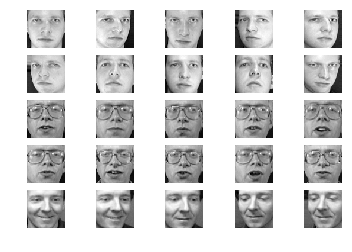

In [25]:
import matplotlib.pyplot as plt

for i in range(25):
    face = faces.images[i]
    plt.subplot(5, 5, i + 1)
    plt.imshow(face.reshape((64, 64)), cmap='gray')
    plt.axis('off')

plt.show()

## 3 - Analysis with SVM

We will try to build a classifier whose model is a hyperplane that separates instances (points) of one class from the rest. Support Vector Machines (SVM) are supervised learning methods that try to obtain these hyperplanes in an optimal way, by selecting the ones that pass through the widest possible gaps between instances of different classes. New instances will be classified as belonging to a certain category based on which side of the surfaces they fall on. Let's import the SVC class from the sklearn.svm module. SVC stands for Support Vector Classifier: we will use SVM for classification.

In [36]:
from sklearn.svm import SVC
svc_1 = SVC(kernel='linear')
print(svc_1)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


Build training and testing sets and perform 5-fold cross-validation (use the ``from sklearn.model_selection`` package for this). Show what all the accuracy scores are and compute the average value. Consult the sklearn documentation and when needed ask your teacher for help.

In [88]:
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score, KFold
from scipy.stats import sem
from sklearn.svm import SVC

svc_1 = SVC(kernel='linear')
data = faces.data
target = faces.target

x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=0)

# 5 fold cross validation
cv = KFold(len(y_train), 5, shuffle=True, random_state=0)
# by default the score used is the one returned by score method of the estimator (accuracy)
scores = cross_val_score(svc_1, x_train, y_train, cv=cv)
print (scores)
print ("Mean score: {0:.3f} (+/-{1:.3f})".format(
        np.mean(scores), sem(scores)))

[ 0.93333333  0.86666667  0.91666667  0.93333333  0.91666667]
Mean score: 0.913 (+/-0.012)


## 4 - Other Metrics

Import the sklearn ``metrics`` package and determine also precision and recall for the test set, for _each class_. 

In [95]:
from sklearn import metrics

y_pred = svc_1.predict(x_test)
print(metrics.classification_report(y_test, y_pred))
# The confusion matrix gives insight on the errors that the classifier made during training
print (metrics.confusion_matrix(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.86      1.00      0.92         6
          1       1.00      1.00      1.00         4
          2       1.00      1.00      1.00         2
          3       1.00      1.00      1.00         1
          4       1.00      1.00      1.00         1
          5       1.00      1.00      1.00         5
          6       1.00      1.00      1.00         4
          7       1.00      0.67      0.80         3
          9       1.00      1.00      1.00         1
         10       1.00      1.00      1.00         4
         11       1.00      1.00      1.00         1
         12       1.00      1.00      1.00         2
         13       1.00      1.00      1.00         3
         14       1.00      1.00      1.00         5
         15       1.00      1.00      1.00         3
         17       1.00      1.00      1.00         6
         19       1.00      1.00      1.00         4
         20       1.00      1.00      1.00   

Let's measure precision and recall on the evaluation set, for _each class_. 

In [96]:
from sklearn import metrics

y_pred = svc_1.predict(x_train)
print(metrics.classification_report(y_train, y_pred))
# The confusion matrix gives insight on the errors that the classifier made during training
print (metrics.confusion_matrix(y_train, y_pred))


             precision    recall  f1-score   support

          0       1.00      1.00      1.00         4
          1       1.00      1.00      1.00         6
          2       1.00      1.00      1.00         8
          3       1.00      1.00      1.00         9
          4       1.00      1.00      1.00         9
          5       1.00      1.00      1.00         5
          6       1.00      1.00      1.00         6
          7       1.00      1.00      1.00         7
          8       1.00      1.00      1.00        10
          9       1.00      1.00      1.00         9
         10       1.00      1.00      1.00         6
         11       1.00      1.00      1.00         9
         12       1.00      1.00      1.00         8
         13       1.00      1.00      1.00         7
         14       1.00      1.00      1.00         5
         15       1.00      1.00      1.00         7
         16       1.00      1.00      1.00        10
         17       1.00      1.00      1.00   

Conclusion performance of SVM for face recognition is incredibly high!

## 5 - Discriminate People with or without Glasses

Now, another problem: Let's try to classify images of people with and without glasses. Mark people with glasses as 1 and people without glasses as 0. 

Create training and test set for the new problem.

Try again with a linear SVM kernel and show a classification report as above.